In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

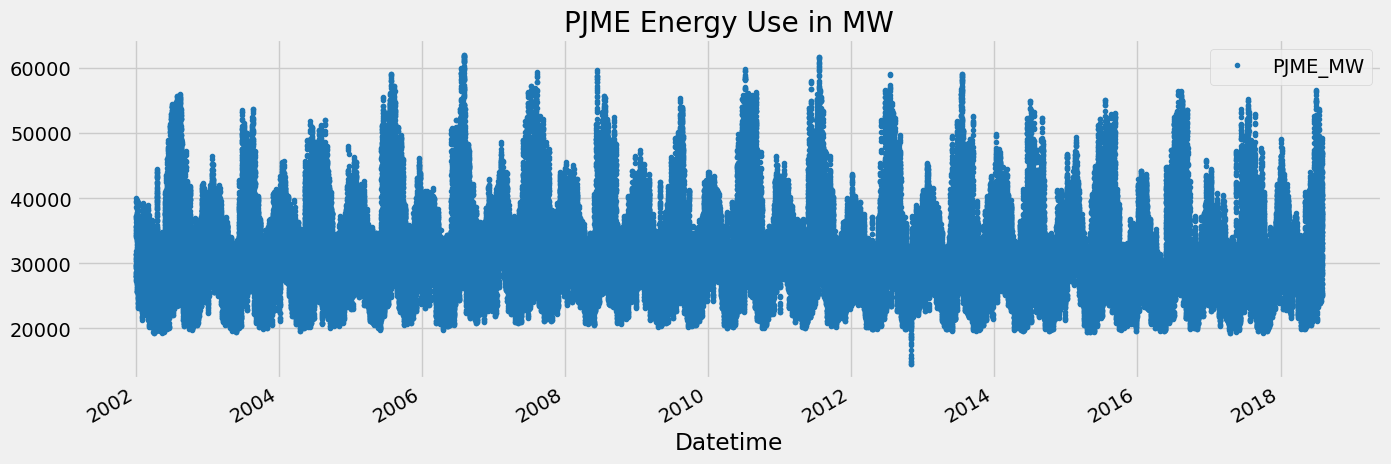

In [4]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Outlier Analysis

<AxesSubplot:ylabel='Frequency'>

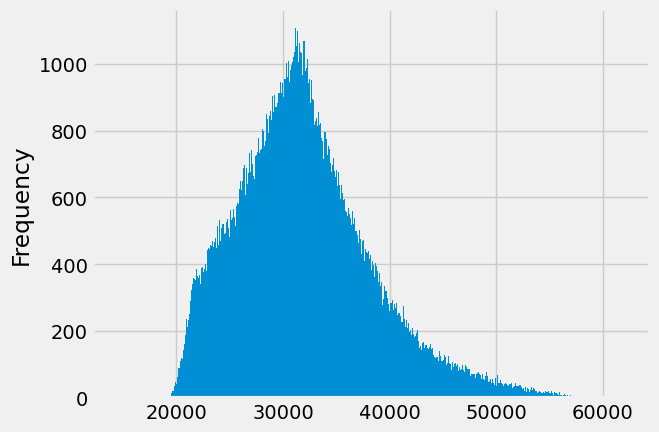

In [5]:
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

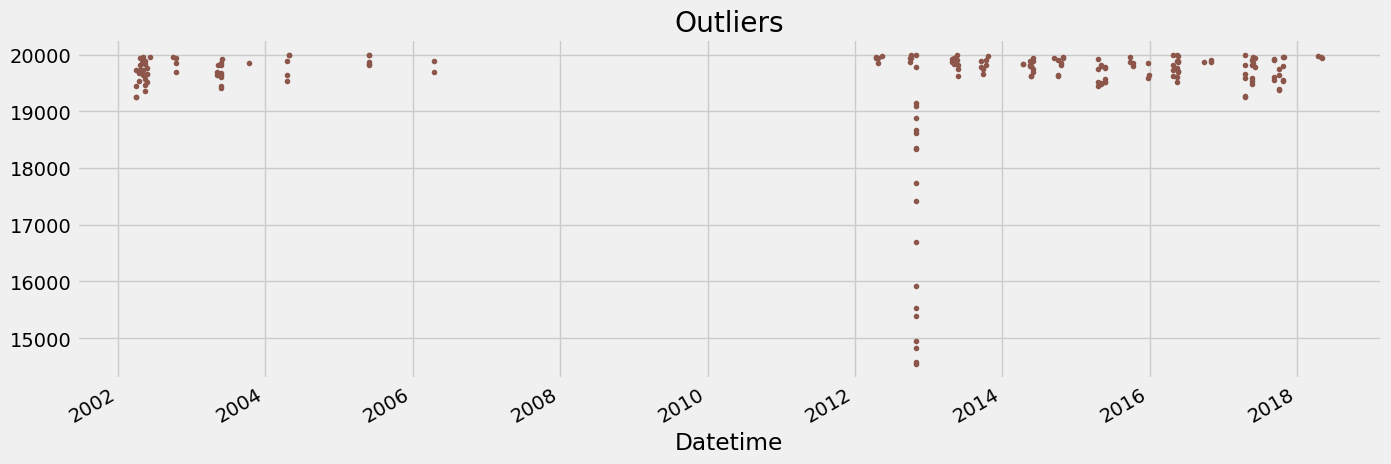

In [7]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

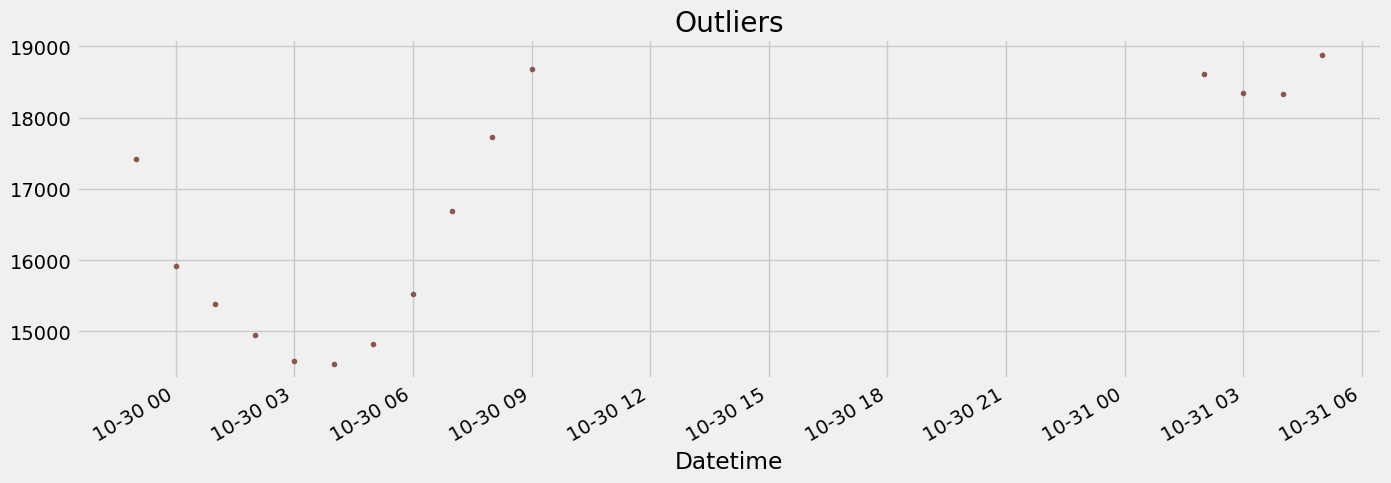

In [8]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [9]:
df = df.query('PJME_MW > 19_000').copy()

# Train / Test Split

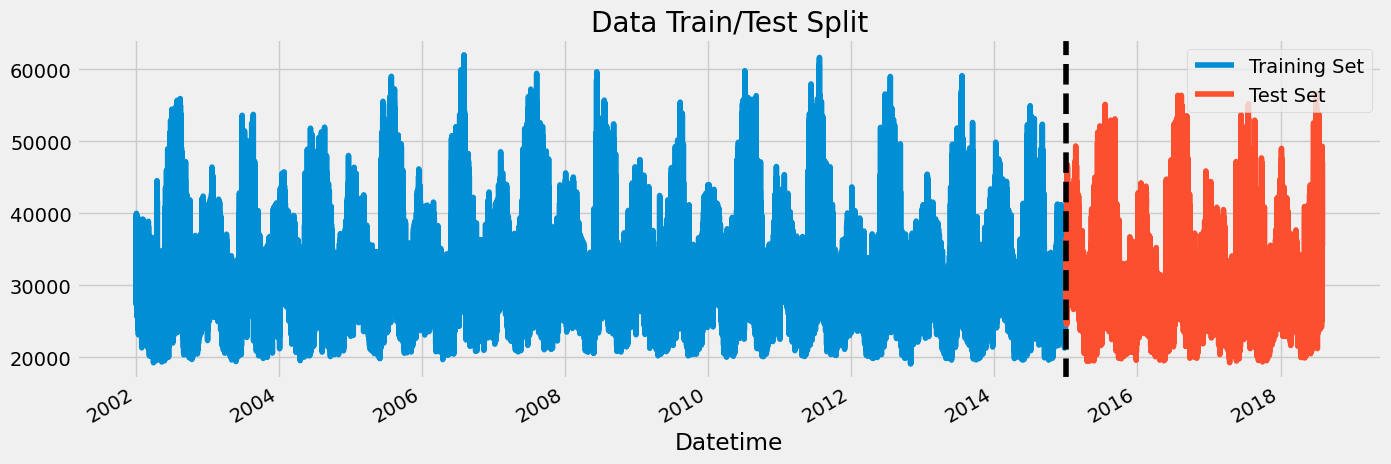

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Time Series Cross Validation

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

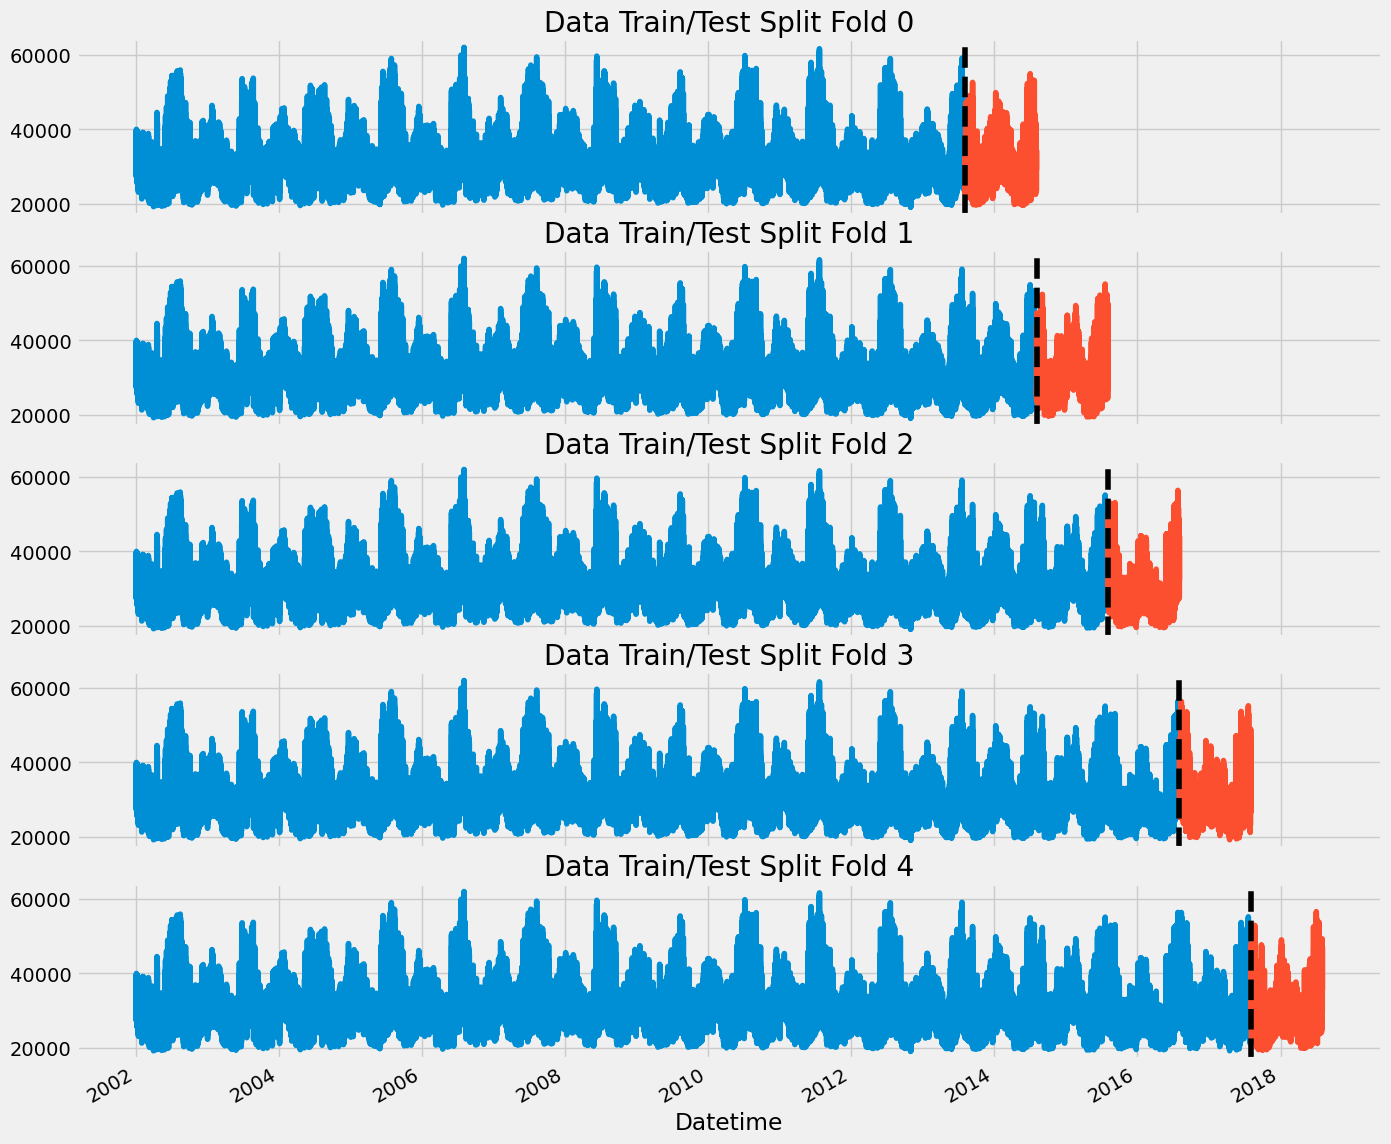

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature Creation

In [19]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

# Lag Features

In [20]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [40]:
df = add_lags(df)

# Model

In [22]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek','month','year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12534.79002	validation_1-rmse:11910.74615
[200]	validation_0-rmse:5761.22862	validation_1-rmse:5376.61825
[300]	validation_0-rmse:3904.78453	validation_1-rmse:3916.75875
[400]	validation_0-rmse:3472.90626	validation_1-rmse:3787.64626
[437]	validation_0-rmse:3415.03424	validation_1-rmse:3796.63218
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12516.15096	validation_1-rmse:12221.84235
[200]	validation_0-rmse:5764.21339	validation_1-rmse:5664.43859
[300]	validation_0-rmse:3938.68639	validation_1-rmse:3967.85941
[400]	validation_0-rmse:3512.53665	validation_1-rmse:3640.71065
[500]	validation_0-rmse:3392.61055	validation_1-rmse:3569.00505
[600]	validation_0-rmse:3337.93156	validation_1-rmse:3538.94705
[700]	validation_0-rmse:3299.69848	validation_1-rmse:3500.28507
[800]	validation_0-rmse:3270.55819	validation_1-rmse:3477.11226
[900]	validation_0-rmse:3246.20964	validation_1-rmse:3459.89265
[999]	validation_0-rmse:3226.07626	validation_1-rmse:3449.99232
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12500.60084	validation_1-rmse:11131.04935
[200]	validation_0-rmse:5759.81042	validation_1-rmse:4847.08808
[300]	validation_0-rmse:3947.85537	validation_1-rmse:3609.08308
[400]	validation_0-rmse:3526.11602	validation_1-rmse:3543.83780
[405]	validation_0-rmse:3517.25106	validation_1-rmse:3547.42660
[0]	validation_0-rmse:32528.46315	validation_1-rmse:31475.87679


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12464.68566	validation_1-rmse:12016.82319
[200]	validation_0-rmse:5747.46661	validation_1-rmse:5809.18349
[300]	validation_0-rmse:3950.12085	validation_1-rmse:4398.22513
[400]	validation_0-rmse:3534.41377	validation_1-rmse:4163.54086
[500]	validation_0-rmse:3418.94720	validation_1-rmse:4097.31100
[600]	validation_0-rmse:3361.12506	validation_1-rmse:4064.71555
[700]	validation_0-rmse:3326.27563	validation_1-rmse:4045.12603
[800]	validation_0-rmse:3298.40550	validation_1-rmse:4030.89203
[900]	validation_0-rmse:3272.86665	validation_1-rmse:4024.36614
[920]	validation_0-rmse:3267.94186	validation_1-rmse:4025.87096
[0]	validation_0-rmse:32462.09266	validation_1-rmse:31464.75483


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12448.39748	validation_1-rmse:11971.63926
[200]	validation_0-rmse:5759.75627	validation_1-rmse:5621.08280
[300]	validation_0-rmse:3982.83927	validation_1-rmse:4144.86633
[400]	validation_0-rmse:3581.15219	validation_1-rmse:3961.44912
[500]	validation_0-rmse:3465.90084	validation_1-rmse:3941.54583
[564]	validation_0-rmse:3431.10455	validation_1-rmse:3943.68410


In [24]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3743.3406
Fold scores:[3784.1631971019824, 3449.7166700296357, 3521.163620549238, 4022.931832756286, 3938.727526711577]


# Feature Importance

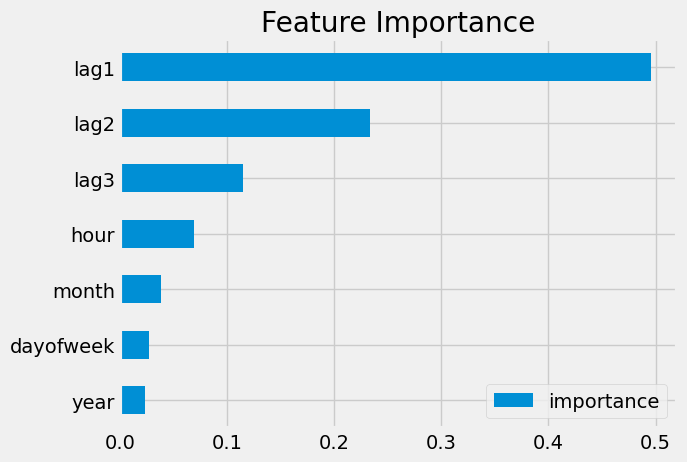

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Data

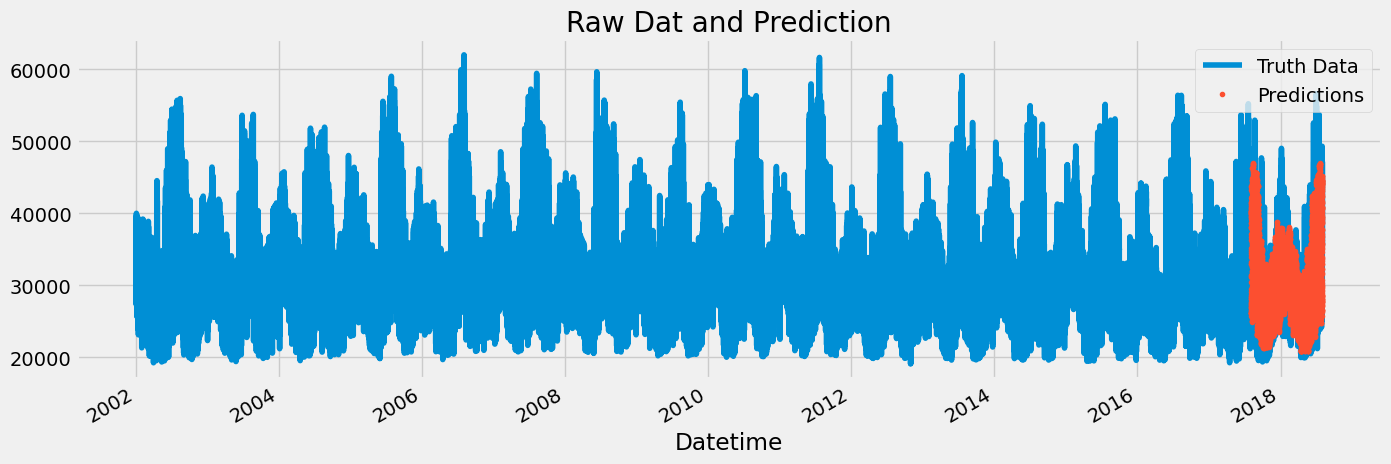

In [26]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

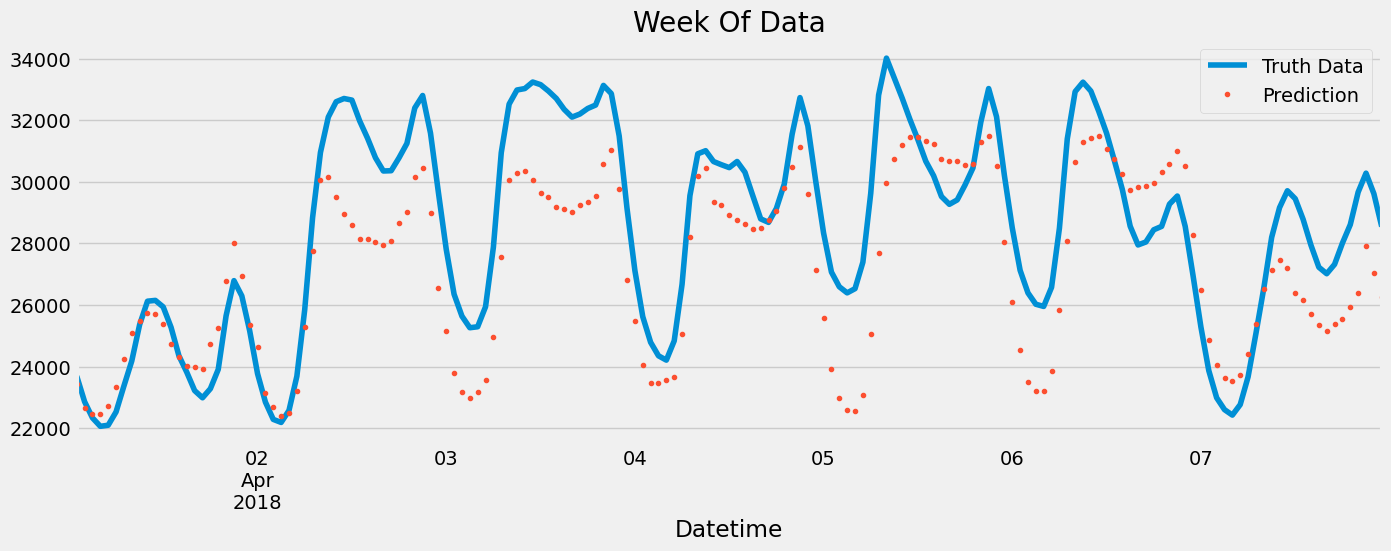

In [27]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# RMSE

In [39]:
print(f'Lowest score: {min(scores)}')

Lowest score: 3449.7166700296357


# Calculated Error

In [29]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-01-06    11063.203206
2017-12-31    11033.910645
2018-01-05    10377.013997
2018-07-02     9978.544596
2017-08-29     9601.104411
2018-01-07     9251.123861
2017-12-28     9179.751302
2017-09-08     8725.474284
2017-08-28     8706.054199
2017-08-30     8701.106201
Name: error, dtype: float64

# Predict the Future

In [31]:
# Retrain on all data
df = create_features(df)

FEATURES = ['hour', 'dayofweek', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.77686


/Users/praneethkruthiventi/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:17:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12429.30333
[200]	validation_0-rmse:5760.15083
[300]	validation_0-rmse:3994.46734
[400]	validation_0-rmse:3601.46425
[499]	validation_0-rmse:3494.09745


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [32]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [33]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [34]:
future_w_features = df_and_future.query('isFuture').copy()

In [35]:
# Predict the future

In [36]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

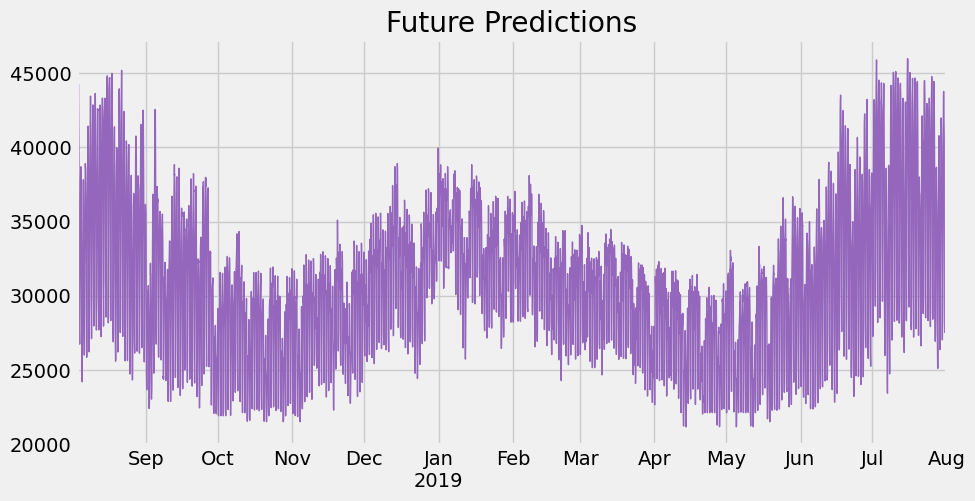

In [37]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()